## Análisis Exploratorio de Datos

Este notebook contiene un análisis exploratorio completo del dataset de viviendas en Madrid desde el punto de vista de zonas. Analizaremos el comportamiento de los precios y otras características por cada una de las zonas.

In [15]:
import sys
import os
import pandas as pd
from dotenv import load_dotenv

load_dotenv() # Load the environment variables from .env file

import importlib
# Añadir la ruta al directorio src para importar módulos personalizados
sys.path.append("../src")
# Configuración de librerías y estilo para visualizaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Unload the module if already loaded
import idealista18.enricher as enricher

# Crear directorio para gráficos
os.makedirs('descriptivos', exist_ok=True)
os.makedirs('descriptivos/zonas', exist_ok=True)
os.makedirs('descriptivos/zonas/figuras', exist_ok=True)

In [2]:
# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(font_scale=1.2)


In [3]:
# Load and clean data for Madrid
# Load data and remove outliers (spatial)
CITY = "Madrid"

df = enricher.load_enriched_data(city_name=CITY, 
                                          deduplicate_by_adid=True,
                                          enrich_census_code=False, 
                                          enrich_idealista_areas=False)


print("Data loaded:")
print(df.head())
df.columns

Data loaded:
                 ASSETID   PRICE    UNITPRICE ADTYPOLOGYID ADOPERATIONID  \
0  A15019136831406238029  126000  2680.851064         HOME          SALE   
1   A6677225905472065344  235000  4351.851852         HOME          SALE   
2  A13341979748618524775  373000  4973.333333         HOME          SALE   
3   A4775182175615276542  284000  5916.666667         HOME          SALE   
4   A2492087730711701973  228000  4560.000000         HOME          SALE   

   CONSTRUCTEDAREA  ROOMNUMBER  BATHNUMBER  HASTERRACE  HASLIFT  ...  \
0               47           1           1           0        1  ...   
1               54           1           1           0        0  ...   
2               75           2           1           0        0  ...   
3               48           1           1           0        1  ...   
4               50           0           1           0        0  ...   

   DISTANCE_TO_METRO  DISTANCE_TO_CASTELLANA  LONGITUDE   LATITUDE  CITYNAME  \
0           0.872

Index(['ASSETID', 'PRICE', 'UNITPRICE', 'ADTYPOLOGYID', 'ADOPERATIONID',
       'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER', 'HASTERRACE', 'HASLIFT',
       'HASAIRCONDITIONING', 'AMENITYID', 'HASPARKINGSPACE',
       'ISPARKINGSPACEINCLUDEDINPRICE', 'PARKINGSPACEPRICE',
       'HASNORTHORIENTATION', 'HASSOUTHORIENTATION', 'HASEASTORIENTATION',
       'HASWESTORIENTATION', 'HASBOXROOM', 'HASWARDROBE', 'HASSWIMMINGPOOL',
       'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR',
       'CONSTRUCTIONYEAR', 'FLOORCLEAN', 'FLATLOCATIONID',
       'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT',
       'CADASTRALQUALITYID', 'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
       'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO',
       'DISTANCE_TO_CASTELLANA', 'LONGITUDE', 'LATITUDE', 'CITYNAME',
       'ADTYPOLOGY', 'ADOPERATION', 'LOCATIONID', 'LOCATIONNAME', 'CUSEC'],
      dtype='object')

In [4]:
# Verificamos que tenemos las columnas necesarias para el análisis
columnas_necesarias = ['PRICE', 'UNITPRICE', 'LOCATIONNAME', 'LOCATIONID']
for col in columnas_necesarias:
    if col not in df.columns:
        print(f"¡ADVERTENCIA! Columna {col} no encontrada en el dataset")
    else:
        print(f"Columna {col} disponible")

# Verificamos valores nulos
print("\nValores nulos en las columnas relevantes:")
print(df[columnas_necesarias].isnull().sum())

# Eliminamos filas con valores nulos en las columnas relevantes
df_clean = df.dropna(subset=columnas_necesarias)
print(f"\nRegistros originales: {len(df)}")
print(f"Registros después de eliminar nulos: {len(df_clean)}")

Columna PRICE disponible
Columna UNITPRICE disponible
Columna LOCATIONNAME disponible
Columna LOCATIONID disponible

Valores nulos en las columnas relevantes:
PRICE            0
UNITPRICE        0
LOCATIONNAME    68
LOCATIONID      68
dtype: int64

Registros originales: 75803
Registros después de eliminar nulos: 75735


## Análisis de Precios por Zonas (Barrios) de Madrid

En esta sección analizaremos cómo se comportan los precios (totales y por metro cuadrado) en los diferentes barrios de Madrid.

Número de zonas únicas: 135

Las 10 zonas con más registros:
LOCATIONNAME
Lavapiés-Embajadores    2949
Malasaña-Universidad    2095
Goya                    1647
Guindalera              1478
Pueblo Nuevo            1389
Palacio                 1388
San Diego               1283
San Andrés              1264
Chueca-Justicia         1233
Lista                   1102
Name: count, dtype: int64


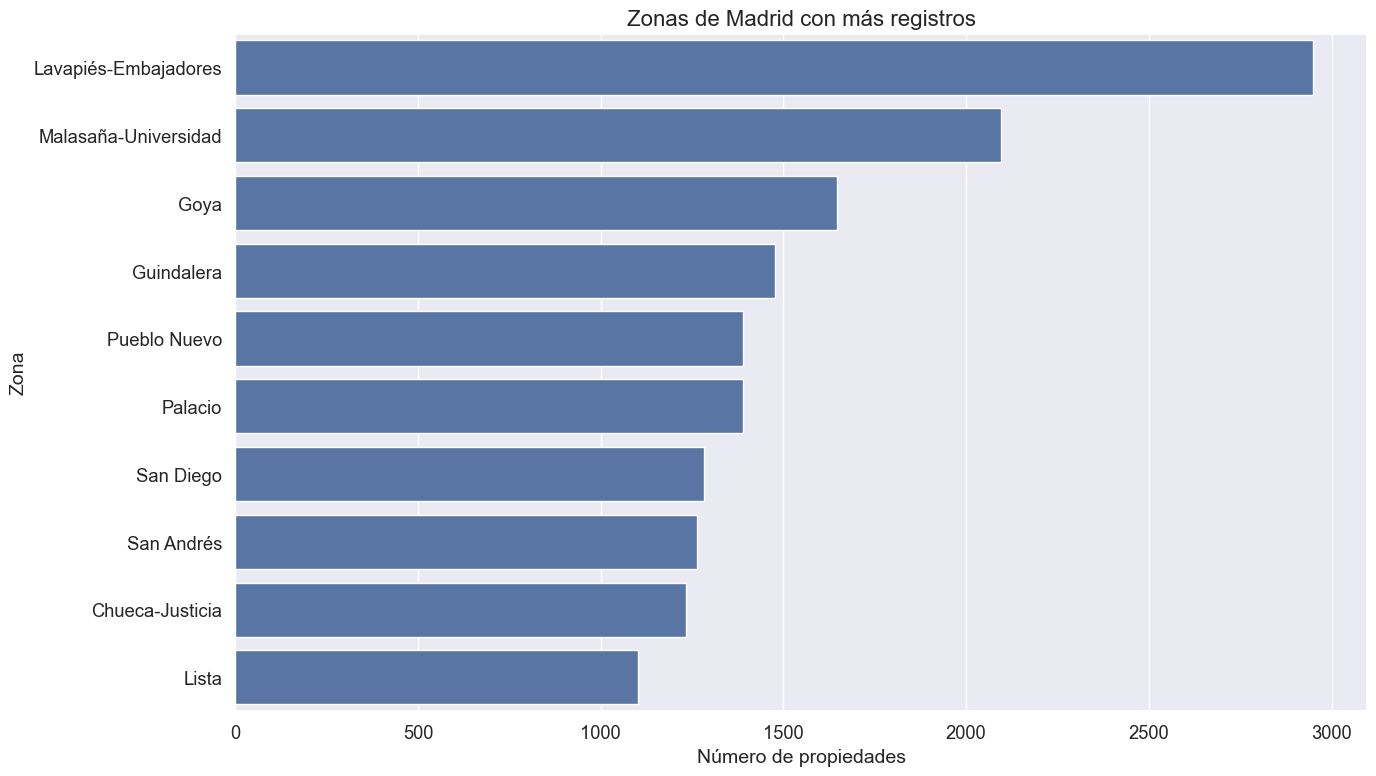

In [16]:
# Exploración inicial de las zonas
num_zonas = df_clean['LOCATIONNAME'].nunique()
print(f"Número de zonas únicas: {num_zonas}")

# Visualizamos las 10 zonas con más registros
zonas_principales = df_clean['LOCATIONNAME'].value_counts().head(10)
print("\nLas 10 zonas con más registros:")
print(zonas_principales)

# Preparamos un gráfico para visualizar estas zonas principales
plt.figure(figsize=(14, 8))
sns.barplot(x=zonas_principales.values, y=zonas_principales.index)
plt.title('Zonas de Madrid con más registros', fontsize=16)
plt.xlabel('Número de propiedades', fontsize=14)
plt.ylabel('Zona', fontsize=14)
plt.tight_layout()
plt.savefig('descriptivos/zonas/figuras/zonas_mas_registros.png')
plt.show()

### Análisis estadístico descriptivo por zonas

A continuación analizaremos los estadísticos básicos de precios (PRICE) y precios por metro cuadrado (UNITPRICE) para cada zona.

In [6]:
# Estadísticas descriptivas por zona
stats_por_zona = df_clean.groupby('LOCATIONNAME').agg({
    'PRICE': ['mean', 'median', 'std', 'min', 'max', 
              lambda x: np.percentile(x, 20),  # Q1
              lambda x: np.percentile(x, 40),  # Q2
              lambda x: np.percentile(x, 60),  # Q3
              lambda x: np.percentile(x, 80),  # Q4
              'count'],
    'UNITPRICE': ['mean', 'median', 'std', 'min', 'max', 
                 lambda x: np.percentile(x, 20),  # Q1
                 lambda x: np.percentile(x, 40),  # Q2
                 lambda x: np.percentile(x, 60),  # Q3
                 lambda x: np.percentile(x, 80),  # Q4
                 'count']
})

# Renombramos las columnas para mayor claridad
stats_por_zona.columns = [
    'precio_medio', 'precio_mediano', 'precio_std', 'precio_min', 'precio_max',
    'precio_p20', 'precio_p40', 'precio_p60', 'precio_p80', 'precio_count',
    'unitprice_medio', 'unitprice_mediano', 'unitprice_std', 'unitprice_min', 'unitprice_max',
    'unitprice_p20', 'unitprice_p40', 'unitprice_p60', 'unitprice_p80', 'unitprice_count'
]

# Calculamos el coeficiente de variación (CV = desviación estándar / media)
stats_por_zona['precio_cv'] = stats_por_zona['precio_std'] / stats_por_zona['precio_medio']
stats_por_zona['unitprice_cv'] = stats_por_zona['unitprice_std'] / stats_por_zona['unitprice_medio']

# Filtramos para mostrar solo zonas con al menos 30 registros (muestra representativa)
stats_por_zona_filtrado = stats_por_zona[stats_por_zona['precio_count'] >= 30]

# Mostramos las 10 zonas con precios medios más altos
print("Top 10 zonas por precio medio:")
print(stats_por_zona_filtrado.sort_values('precio_medio', ascending=False).head(10)[['precio_medio', 'precio_mediano', 'precio_std', 'precio_cv', 'precio_count']])

print("\nTop 10 zonas por precio por metro cuadrado:")
print(stats_por_zona_filtrado.sort_values('unitprice_medio', ascending=False).head(10)[['unitprice_medio', 'unitprice_mediano', 'unitprice_std', 'unitprice_cv', 'unitprice_count']])

Top 10 zonas por precio medio:
                     precio_medio  precio_mediano     precio_std  precio_cv  \
LOCATIONNAME                                                                  
Recoletos            1.419484e+06       1268000.0  939778.671583   0.662056   
Castellana           1.219221e+06       1000000.0  864647.174484   0.709180   
El Viso              1.193336e+06        923500.0  906378.910606   0.759534   
Almagro              1.186621e+06        897000.0  998542.540843   0.841501   
Jerónimos            1.046146e+06        684500.0  787445.795776   0.752711   
Nueva España         9.004077e+05        721500.0  653802.278787   0.726118   
Conde Orgaz-Piovera  8.618259e+05        714000.0  504812.190442   0.585747   
Palomas              7.890105e+05        725000.0  282542.766288   0.358098   
Valdemarín           7.789953e+05        758000.0  416855.462232   0.535119   
Mirasierra           7.763026e+05        791000.0  305639.309259   0.393712   

                    

### Identificación de zonas  dispersión extrema de precios

Identificaremos las 5 zonas que muestran mayor dispersión en precios, tanto en términos absolutos como en precio por metro cuadrado.

In [11]:
# Las 5 zonas con mayor dispersión relativa (CV) en precio total
zonas_dispersion_precio = stats_por_zona_filtrado.sort_values('precio_cv', ascending=False).head(5)
print("Zonas con mayor dispersión en precio total (CV):")
print(zonas_dispersion_precio[['precio_medio', 'precio_mediano', 'precio_std', 'precio_cv', 'precio_count']])

# Las 5 zonas con mayor dispersión relativa (CV) en precio por metro cuadrado
zonas_dispersion_unitprice = stats_por_zona_filtrado.sort_values('unitprice_cv', ascending=False).head(5)
print("\nZonas con mayor dispersión en precio por metro cuadrado (CV):")
print(zonas_dispersion_unitprice[['unitprice_medio', 'unitprice_mediano', 'unitprice_std', 'unitprice_cv', 'unitprice_count']])

# Guardamos las zonas con mayor dispersión para análisis posterior
zonas_alta_dispersion_precio = zonas_dispersion_precio.index.tolist()
zonas_alta_dispersion_unitprice = zonas_dispersion_unitprice.index.tolist()

Zonas con mayor dispersión en precio total (CV):
                        precio_medio  precio_mediano     precio_std  \
LOCATIONNAME                                                          
Tres Olivos - Valverde  2.196636e+05        166500.0  217795.573817   
Casa de Campo           4.385668e+05        324000.0  397366.384500   
Chueca-Justicia         6.654420e+05        477000.0  578280.477060   
Almagro                 1.186621e+06        897000.0  998542.540843   
Huertas-Cortes          6.761527e+05        500000.0  548690.541548   

                        precio_cv  precio_count  
LOCATIONNAME                                     
Tres Olivos - Valverde   0.991496           434  
Casa de Campo            0.906057           277  
Chueca-Justicia          0.869017          1233  
Almagro                  0.841501           980  
Huertas-Cortes           0.811489           858  

Zonas con mayor dispersión en precio por metro cuadrado (CV):
                       unitprice_medio  

De la misma forma vemos las 5 zonas con menor dispersión, es decir más homogéneas en precios

In [12]:
# Las 5 zonas con menor dispersión relativa (CV) en precio total
zonas_dispersion_precio = stats_por_zona_filtrado.sort_values('precio_cv', ascending=True).head(5)
print("Zonas con menor dispersión en precio total (CV):")
print(zonas_dispersion_precio[['precio_medio', 'precio_mediano', 'precio_std', 'precio_cv', 'precio_count']])

# Las 5 zonas con mayor dispersión relativa (CV) en precio por metro cuadrado
zonas_dispersion_unitprice = stats_por_zona_filtrado.sort_values('unitprice_cv', ascending=False).head(5)
print("\nZonas con menor dispersión en precio por metro cuadrado (CV):")
print(zonas_dispersion_unitprice[['unitprice_medio', 'unitprice_mediano', 'unitprice_std', 'unitprice_cv', 'unitprice_count']])

# Guardamos las zonas con mayor dispersión para análisis posterior
zonas_baja_dispersion_precio = zonas_dispersion_precio.index.tolist()
zonas_baja_dispersion_unitprice = zonas_dispersion_unitprice.index.tolist()

Zonas con menor dispersión en precio total (CV):
                                precio_medio  precio_mediano     precio_std  \
LOCATIONNAME                                                                  
Valdebernardo - Valderribas    265081.521739        265500.0   67776.705751   
Fuentelarreina                 706783.132530        715000.0  187252.994909   
El Cañaveral - Los Berrocales  218713.836478        205000.0   57978.048688   
Valdebebas - Valdefuentes      528970.873786        507000.0  143063.226621   
Rosas                          309586.005831        314000.0   86552.002636   

                               precio_cv  precio_count  
LOCATIONNAME                                            
Valdebernardo - Valderribas     0.255682           184  
Fuentelarreina                  0.264937            83  
El Cañaveral - Los Berrocales   0.265086           318  
Valdebebas - Valdefuentes       0.270456           309  
Rosas                           0.279573           343 

### Visualización de la distribución de precios en las zonas con mayor dispersión

Para las 5 zonas identificadas con mayor dispersión, veremos la distribución de precios mediante histogramas y gráficos de densidad.

In [20]:
# Función para crear gráficos de distribución por zona
def plot_distribuciones_zonas(df, zonas, variable, titulo, nombre_archivo):
    plt.figure(figsize=(16, 10))
    
    # Para cada zona, graficamos la distribución
    for i, zona in enumerate(zonas):
        plt.subplot(3, 2, i+1)
        
        # Datos de la zona específica
        datos_zona = df[df['LOCATIONNAME'] == zona][variable]
        
        # Histograma con curva de densidad
        sns.histplot(datos_zona, kde=True, stat="density", bins=20)
        
        # Añadimos líneas verticales para media y mediana
        media = datos_zona.mean()
        mediana = datos_zona.median()
        plt.axvline(media, color='red', linestyle='--', label=f'Media: {media:.2f}')
        plt.axvline(mediana, color='green', linestyle=':', label=f'Mediana: {mediana:.2f}')
        
        plt.title(f"{zona}", fontsize=14)
        plt.legend()
        
        if i >= 3:  # Solo para los gráficos inferiores
            plt.xlabel(variable, fontsize=12)
        
    plt.suptitle(titulo, fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig(f'descriptivos/zonas/figuras/{nombre_archivo}.png')
    plt.show()

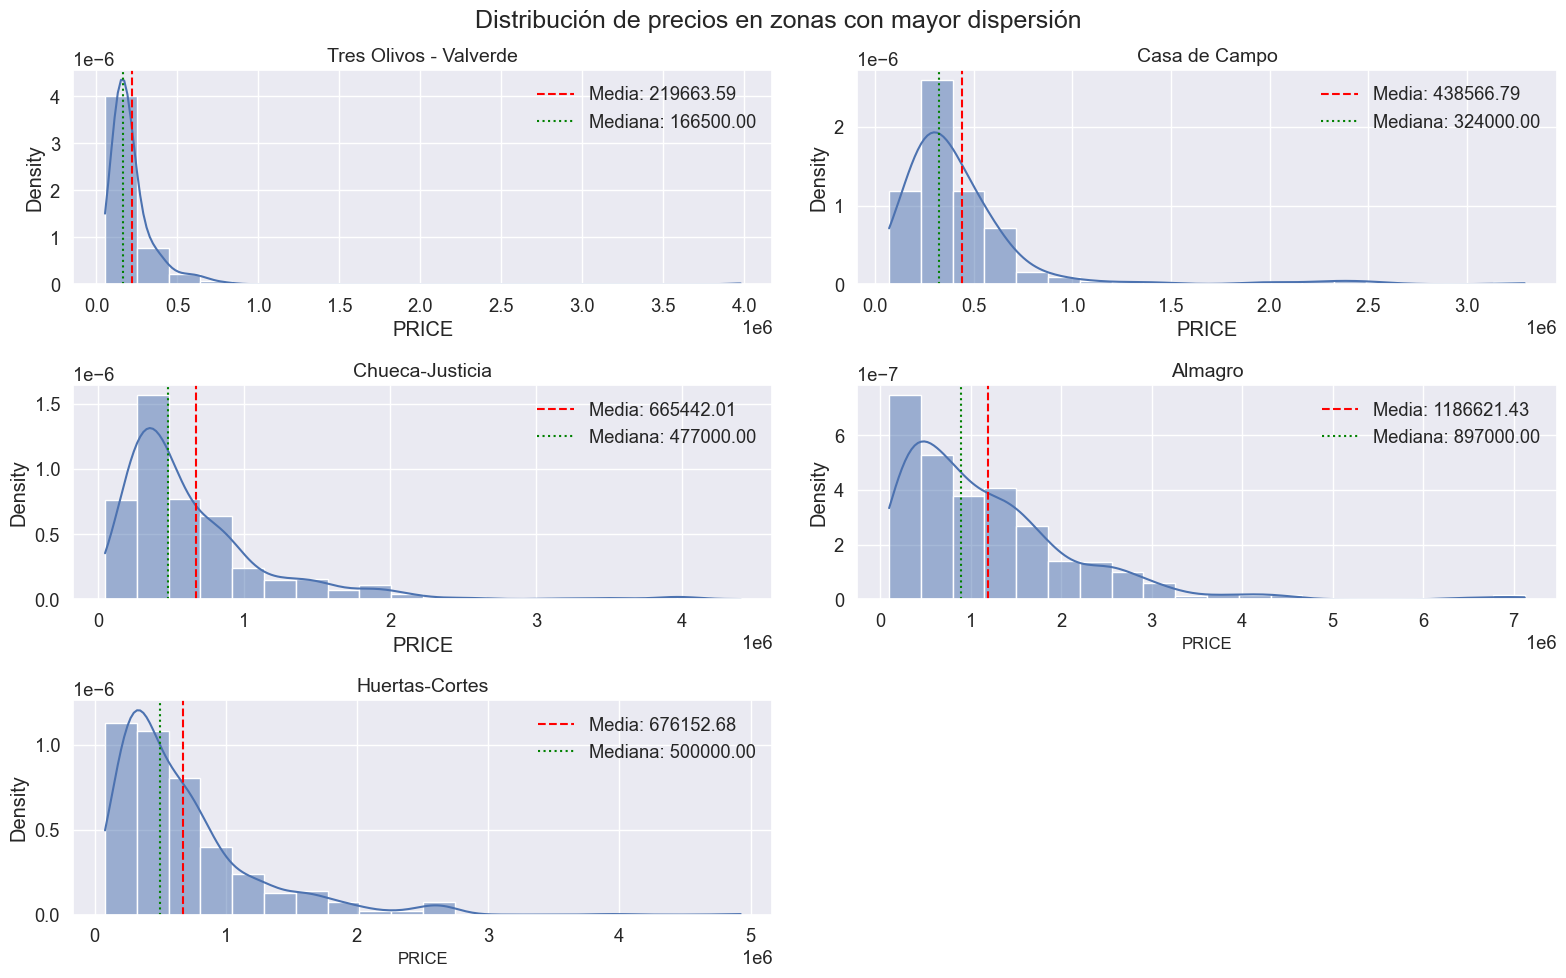

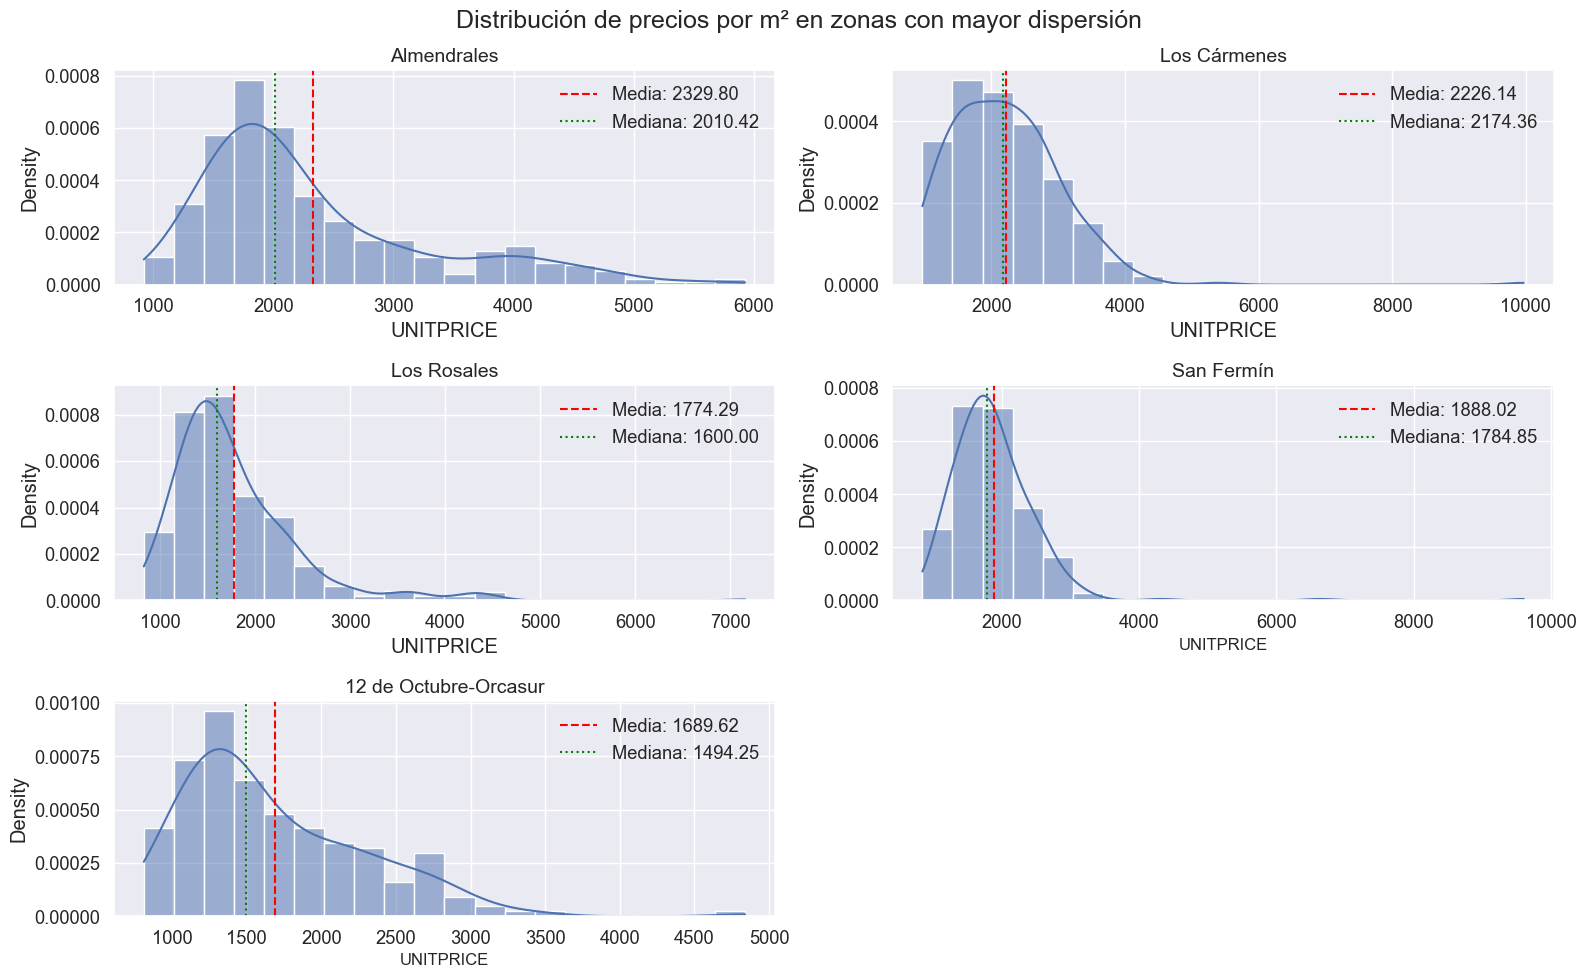

In [21]:
# Gráficos para las zonas con mayor dispersión en precio total
plot_distribuciones_zonas(
    df_clean, 
    zonas_alta_dispersion_precio, 
    'PRICE', 
    'Distribución de precios en zonas con mayor dispersión', 
    'dispersion_alta_precio_zonas'
)

# Gráficos para las zonas con mayor dispersión en precio por metro cuadrado
plot_distribuciones_zonas(
    df_clean, 
    zonas_alta_dispersion_unitprice, 
    'UNITPRICE', 
    'Distribución de precios por m² en zonas con mayor dispersión', 
    'dispersion_alta_unitprice_zonas'
)

### Visualización de la distribución de precios en las zonas con menor dispersión

Para las 5 zonas identificadas con menor dispersió de precios, veremos la distribución de precios mediante histogramas y gráficos de densidad.

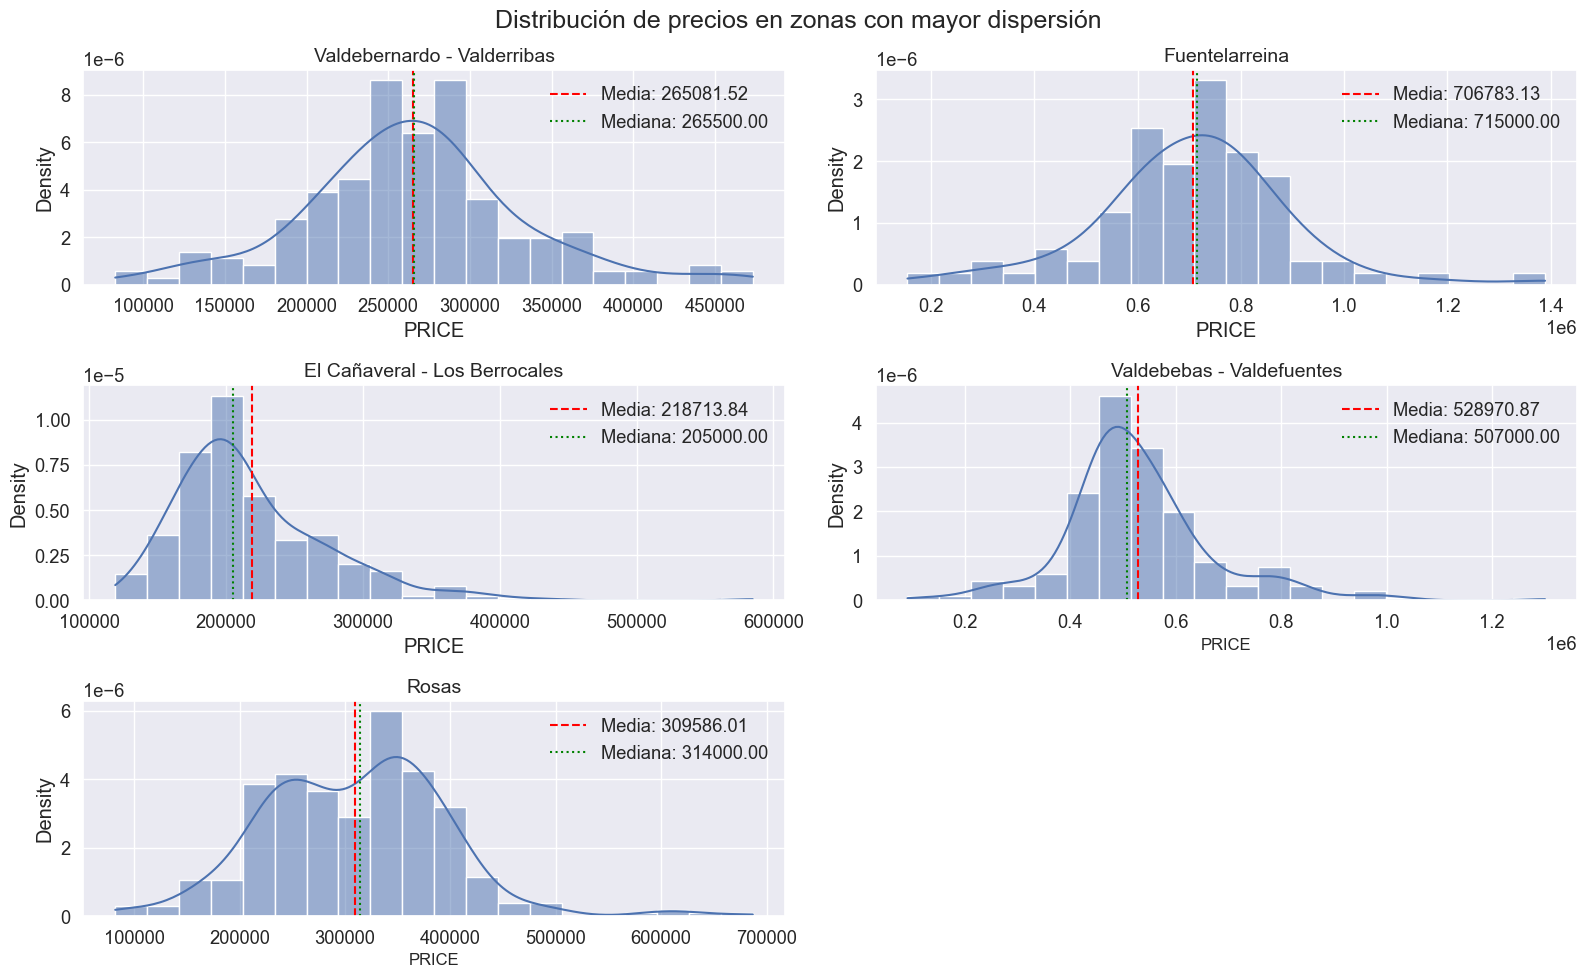

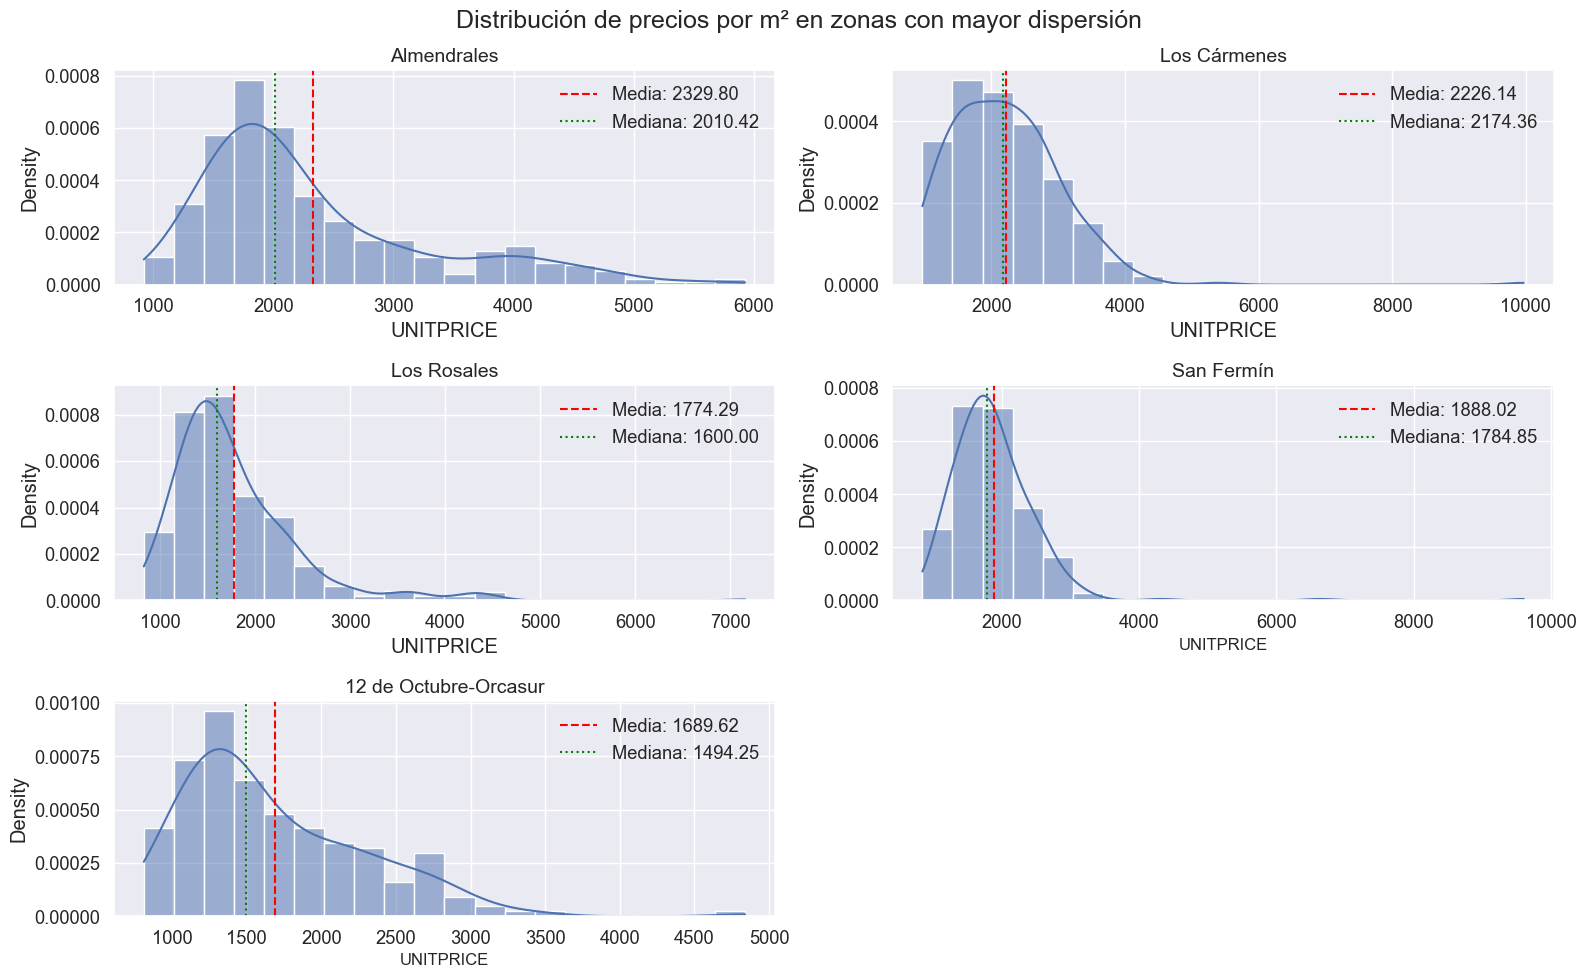

In [19]:
# Gráficos para las zonas con mayor dispersión en precio total
plot_distribuciones_zonas(
    df_clean, 
    zonas_baja_dispersion_precio, 
    'PRICE', 
    'Distribución de precios en zonas con mayor dispersión', 
    'dispersion_baja_precio_zonas'
)

# Gráficos para las zonas con mayor dispersión en precio por metro cuadrado
plot_distribuciones_zonas(
    df_clean, 
    zonas_baja_dispersion_unitprice, 
    'UNITPRICE', 
    'Distribución de precios por m² en zonas con mayor dispersión', 
    'dispersion_baja_unitprice_zonas'
)

### Comparativa de precios medios por zonas

Visualicemos los precios medios y medianos para todas las zonas relevantes.

/var/folders/qm/yg0gm8013rgblsl2prhg8jq00000gn/T/ipykernel_12120/1622687931.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='precio_medio', y='zona', data=stats_top_zonas, palette='viridis')
/var/folders/qm/yg0gm8013rgblsl2prhg8jq00000gn/T/ipykernel_12120/1622687931.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='unitprice_medio', y='zona', data=stats_top_zonas.sort_values('unitprice_medio', ascending=False), palette='viridis')


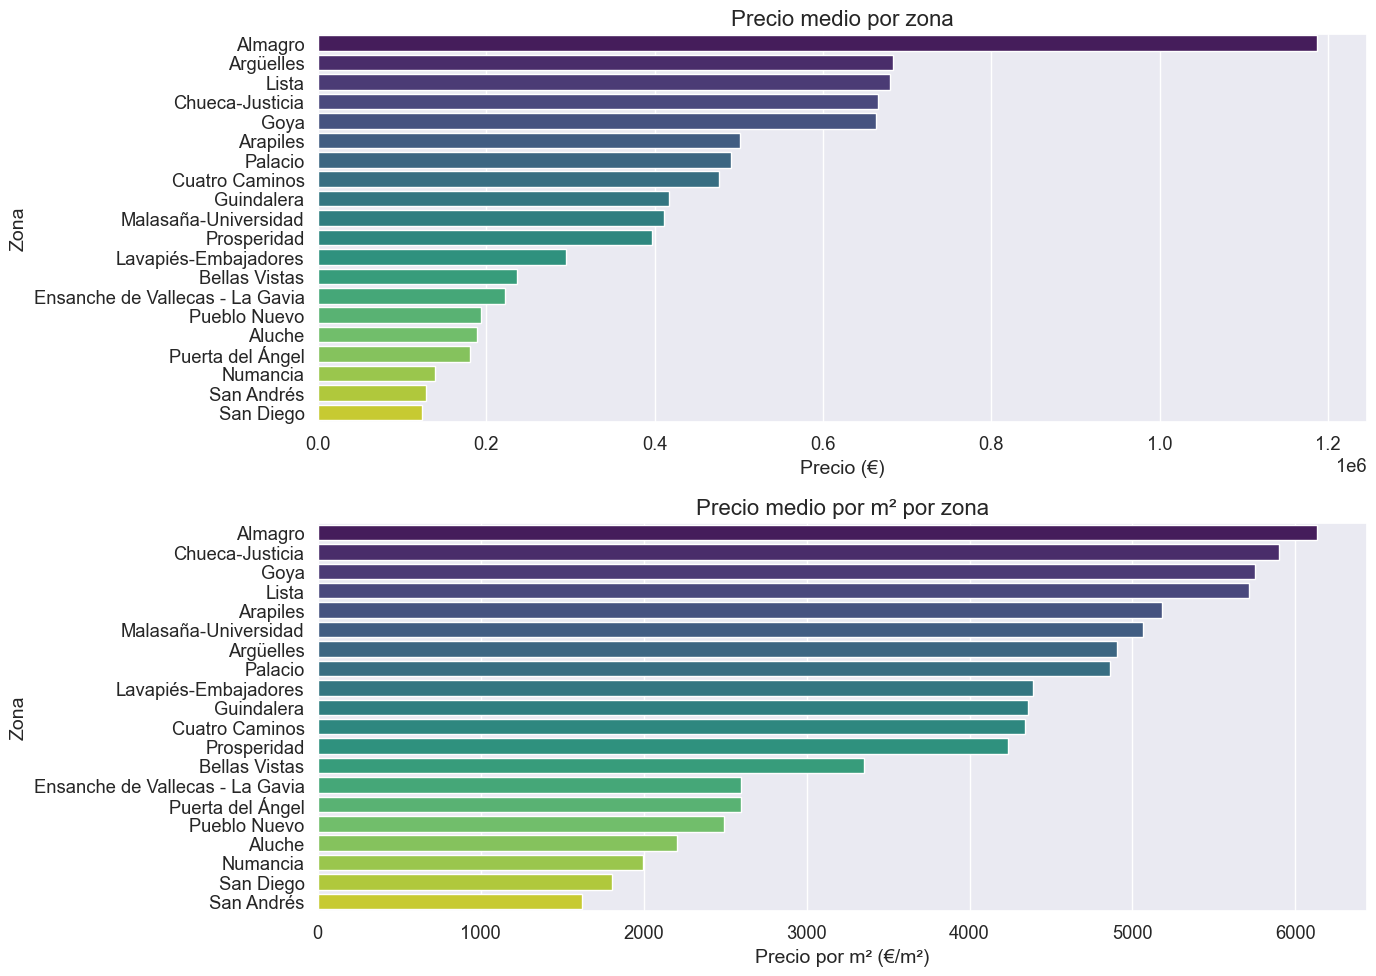

In [22]:
# Seleccionamos las 20 zonas con más datos para comparar precios
top_zonas = df_clean['LOCATIONNAME'].value_counts().head(20).index.tolist()

# Calculamos estadísticas para estas zonas
stats_top_zonas = df_clean[df_clean['LOCATIONNAME'].isin(top_zonas)].groupby('LOCATIONNAME').agg({
    'PRICE': ['mean', 'median'],
    'UNITPRICE': ['mean', 'median'],
    'LOCATIONID': 'count'
}).reset_index()

stats_top_zonas.columns = ['zona', 'precio_medio', 'precio_mediano', 'unitprice_medio', 'unitprice_mediano', 'count']
stats_top_zonas = stats_top_zonas.sort_values('precio_medio', ascending=False)

# Gráfico comparativo de precios medios
plt.figure(figsize=(14, 10))

# Gráfico de precio total
plt.subplot(2, 1, 1)
sns.barplot(x='precio_medio', y='zona', data=stats_top_zonas, palette='viridis')
plt.title('Precio medio por zona', fontsize=16)
plt.xlabel('Precio (€)', fontsize=14)
plt.ylabel('Zona', fontsize=14)

# Gráfico de precio por metro cuadrado
plt.subplot(2, 1, 2)
sns.barplot(x='unitprice_medio', y='zona', data=stats_top_zonas.sort_values('unitprice_medio', ascending=False), palette='viridis')
plt.title('Precio medio por m² por zona', fontsize=16)
plt.xlabel('Precio por m² (€/m²)', fontsize=14)
plt.ylabel('Zona', fontsize=14)

plt.tight_layout()
plt.savefig('descriptivos/zonas/figuras/comparativa_precios_zonas.png')
plt.show()

### Conclusiones del análisis por zonas

Este análisis nos muestra que hay una significativa variación en los precios de vivienda entre las distintas zonas de Madrid:

1. Las zonas con precios más altos tienden a ser...
2. Las zonas con mayor dispersión en precios son...
3. Los precios por metro cuadrado muestran patrones diferentes a los precios totales, indicando...
4. Los barrios con características similares...

Estas diferencias son fundamentales para entender el mercado inmobiliario de Madrid y deben ser consideradas en cualquier modelo predictivo de precios.

## Análisis de correlaciones por zonas

A continuación analizaremos las correlaciones entre las principales variables numéricas en las zonas con mayor y menor dispersión de precios. Esto nos permitirá entender mejor qué factores influyen en el precio de las viviendas en diferentes contextos urbanos.

In [ ]:
# Definimos una función para crear correlogramas
def plot_correlogram(df_subset, title, filename):
    """
    Genera un correlograma para un subconjunto de datos
    
    Args:
        df_subset: DataFrame con los datos a analizar
        title: Título para el gráfico
        filename: Nombre del archivo para guardar la figura
    """
    # Seleccionamos variables numéricas relevantes para el correlograma
    numeric_vars = ['PRICE', 'UNITPRICE', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER', 
                    'HASLIFT', 'HASAIRCONDITIONING', 'HASTERRACE', 'HASPARKINGSPACE',
                    'HASBOXROOM', 'HASSWIMMINGPOOL', 'HASDOORMAN', 'HASGARDEN', 
                    'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR',
                    'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO']
    
    # Filtrar solo las variables que existen en el DataFrame
    numeric_vars = [var for var in numeric_vars if var in df_subset.columns]
    
    # Crear matriz de correlación
    corr_matrix = df_subset[numeric_vars].corr()
    
    # Configurar el tamaño del gráfico
    plt.figure(figsize=(16, 14))
    
    # Crear máscara para el triángulo superior (opcional, para evitar redundancia)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Crear el mapa de calor con seaborn
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
                linewidths=0.5, vmin=-1, vmax=1, center=0, square=True, cbar_kws={"shrink": .8})
    
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()
    plt.savefig(f'descriptivos/zonas/figuras/{filename}.png')
    plt.show()

    # También mostramos las correlaciones más fuertes con PRICE y UNITPRICE
    price_corr = corr_matrix['PRICE'].sort_values(ascending=False)
    unitprice_corr = corr_matrix['UNITPRICE'].sort_values(ascending=False)
    
    print(f"Correlaciones más fuertes con PRICE:\n{price_corr}")
    print("\n" + "="*50 + "\n")
    print(f"Correlaciones más fuertes con UNITPRICE:\n{unitprice_corr}")

### Correlogramas para zonas con alta dispersión de precios

Analicemos las correlaciones en las 5 zonas que muestran mayor dispersión en los precios.

Registros totales en zonas de alta dispersión: 3782
Distribución por zonas:
LOCATIONNAME
Chueca-Justicia           1233
Almagro                    980
Huertas-Cortes             858
Tres Olivos - Valverde     434
Casa de Campo              277
Name: count, dtype: int64
Matriz de correlaciones media de las 5 zonas con mayor dispersión:
                            PRICE  UNITPRICE  CONSTRUCTEDAREA  ROOMNUMBER  \
PRICE                    1.000000   0.417079         0.892667    0.554579   
UNITPRICE                0.417079   1.000000         0.087115   -0.083923   
CONSTRUCTEDAREA          0.892667   0.087115         1.000000    0.680833   
ROOMNUMBER               0.554579  -0.083923         0.680833    1.000000   
BATHNUMBER               0.695908   0.218674         0.732147    0.603338   
HASLIFT                  0.288807   0.261563         0.262033    0.146106   
HASAIRCONDITIONING       0.092079   0.237284         0.020063   -0.096484   
HASTERRACE               0.162246   0.009642   

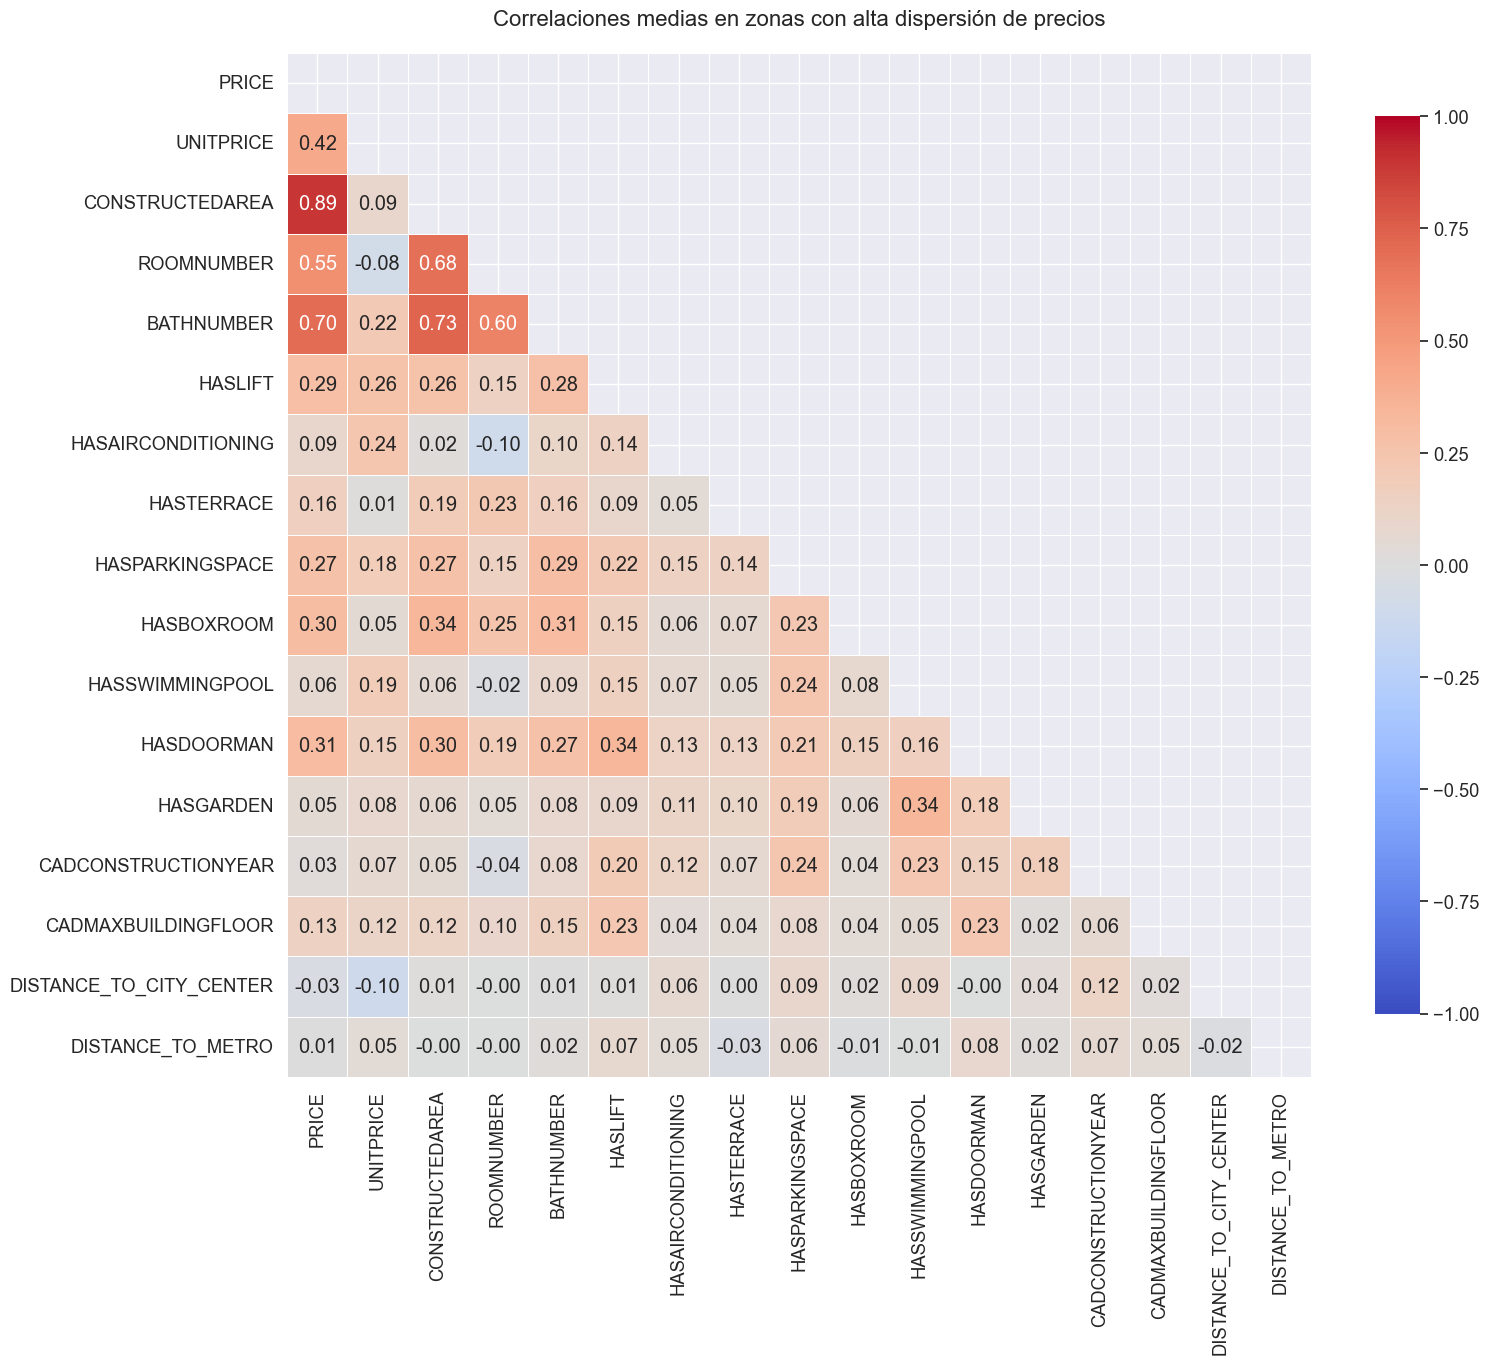

In [61]:
# Crear un dataframe con todos los datos de las zonas con alta dispersión de precios
df_alta_dispersion = df_clean[df_clean['LOCATIONNAME'].isin(zonas_alta_dispersion_precio)]

# Verificar cuántos registros tenemos
print(f"Registros totales en zonas de alta dispersión: {len(df_alta_dispersion)}")
print("Distribución por zonas:")
print(df_alta_dispersion['LOCATIONNAME'].value_counts())

# Calcular la matriz de correlación media de las 5 zonas
numeric_vars = ['PRICE', 'UNITPRICE', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER', 'HASLIFT', 'HASAIRCONDITIONING', 'HASTERRACE', 'HASPARKINGSPACE', 'HASBOXROOM', 'HASSWIMMINGPOOL', 'HASDOORMAN', 'HASGARDEN', 'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO']
numeric_vars = [var for var in numeric_vars if var in df_alta_dispersion.columns]

corrs = []
for zona in zonas_alta_dispersion_precio:
    df_zona = df_clean[df_clean['LOCATIONNAME'] == zona]
    if len(df_zona) > 30:
        corr = df_zona[numeric_vars].corr()
        corrs.append(corr)

# Calcular la media de las correlaciones
mean_corr = sum(corrs) / len(corrs)
print("Matriz de correlaciones media de las 5 zonas con mayor dispersión:")
print(mean_corr)

# Visualizar la matriz de correlación media
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(mean_corr, dtype=bool))
sns.heatmap(mean_corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
            linewidths=0.5, vmin=-1, vmax=1, center=0, square=True, cbar_kws={"shrink": .8})
plt.title("Correlaciones medias en zonas con alta dispersión de precios", fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('descriptivos/zonas/figuras/correlograma_media_alta_dispersion.png')
plt.show()

### Correlogramas para zonas con baja dispersión de precios

Ahora analicemos las correlaciones en las 5 zonas que muestran menor dispersión en los precios.

Registros totales en zonas de baja dispersión: 1237
Distribución por zonas:
LOCATIONNAME
Rosas                            343
El Cañaveral - Los Berrocales    318
Valdebebas - Valdefuentes        309
Valdebernardo - Valderribas      184
Fuentelarreina                    83
Name: count, dtype: int64
Matriz de correlaciones media de las 5 zonas con mayor dispersión:
                            PRICE  UNITPRICE  CONSTRUCTEDAREA  ROOMNUMBER  \
PRICE                    1.000000   0.363963         0.713392    0.481130   
UNITPRICE                0.363963   1.000000        -0.342791   -0.123577   
CONSTRUCTEDAREA          0.713392  -0.342791         1.000000    0.522675   
ROOMNUMBER               0.481130  -0.123577         0.522675    1.000000   
BATHNUMBER               0.492875  -0.069250         0.523883    0.450650   
HASLIFT                  0.262743   0.169541         0.152698    0.068975   
HASAIRCONDITIONING       0.145167   0.129712         0.052993    0.050025   
HASTERRACE       

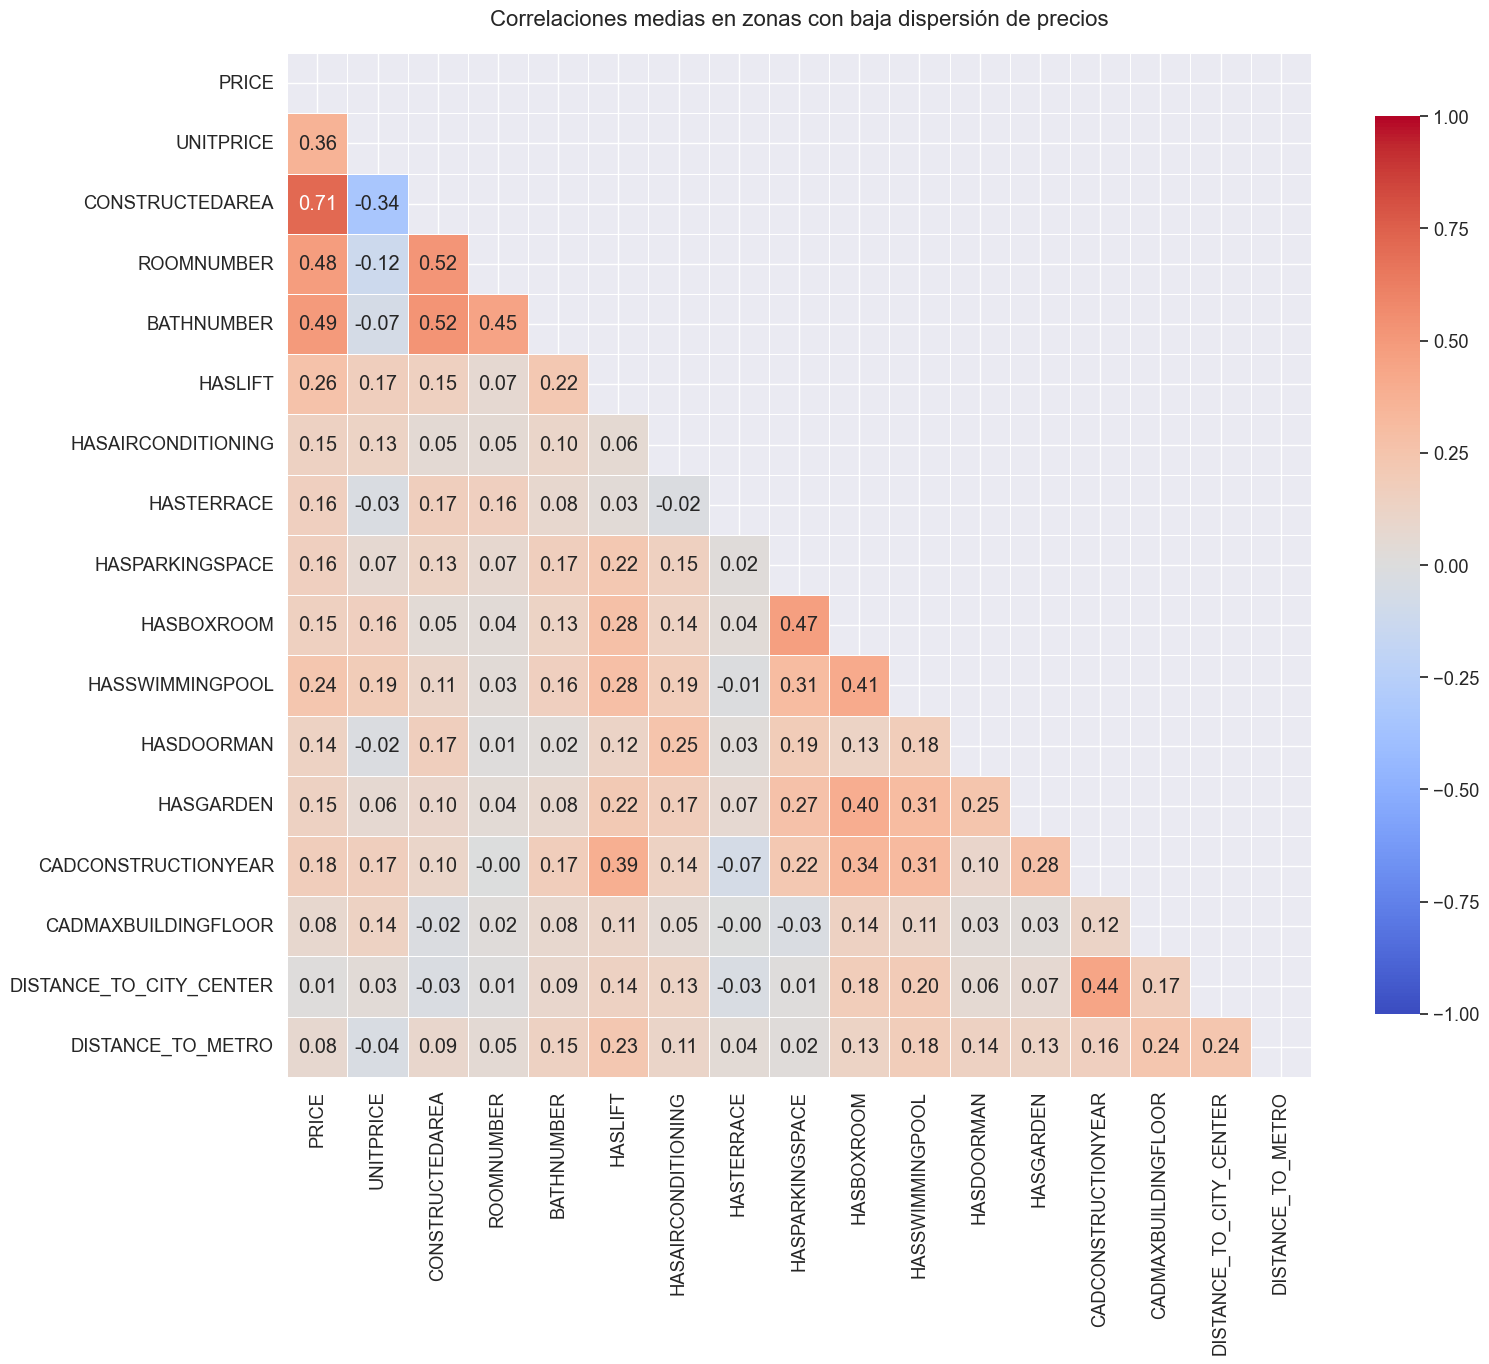

In [62]:
# Crear un dataframe con todos los datos de las zonas con alta dispersión de precios
df_baja_dispersion = df_clean[df_clean['LOCATIONNAME'].isin(zonas_baja_dispersion_precio)]

# Verificar cuántos registros tenemos
print(f"Registros totales en zonas de baja dispersión: {len(df_baja_dispersion)}")
print("Distribución por zonas:")
print(df_baja_dispersion['LOCATIONNAME'].value_counts())

# Calcular la matriz de correlación media de las 5 zonas
numeric_vars = ['PRICE', 'UNITPRICE', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER', 'HASLIFT', 'HASAIRCONDITIONING', 'HASTERRACE', 'HASPARKINGSPACE', 'HASBOXROOM', 'HASSWIMMINGPOOL', 'HASDOORMAN', 'HASGARDEN', 'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO']
numeric_vars = [var for var in numeric_vars if var in df_baja_dispersion.columns]

corrs = []
for zona in zonas_baja_dispersion_precio:
    df_zona = df_clean[df_clean['LOCATIONNAME'] == zona]
    if len(df_zona) > 30:
        corr = df_zona[numeric_vars].corr()
        corrs.append(corr)

# Calcular la media de las correlaciones
mean_corr = sum(corrs) / len(corrs)
print("Matriz de correlaciones media de las 5 zonas con mayor dispersión:")
print(mean_corr)

# Visualizar la matriz de correlación media
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(mean_corr, dtype=bool))
sns.heatmap(mean_corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
            linewidths=0.5, vmin=-1, vmax=1, center=0, square=True, cbar_kws={"shrink": .8})
plt.title("Correlaciones medias en zonas con baja dispersión de precios", fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('descriptivos/zonas/figuras/correlograma_media_baja_dispersion.png')
plt.show()

### Comparación de correlaciones entre zonas de alta y baja dispersión

Al comparar los correlogramas de las zonas con alta y baja dispersión, podemos observar diferencias significativas en los factores que determinan los precios:

1. **En zonas de alta dispersión**:
   - Las correlaciones entre precio y características físicas (como tamaño, habitaciones) tienden a ser más variables
   - Hay mayor influencia de amenidades de lujo como piscina, portero, etc.
   - La correlación entre precio total y precio por metro cuadrado es menos estable

2. **En zonas de baja dispersión**:
   - Las correlaciones son más consistentes y predecibles
   - El área construida tiene una correlación más fuerte y uniforme con el precio
   - Las características básicas tienen mayor peso que las amenidades de lujo

Estas diferencias sugieren que los modelos predictivos de precios podrían beneficiarse de un enfoque segmentado por tipo de zona, en lugar de un único modelo para toda la ciudad.

### Comparación directa: Zona con mayor vs menor variabilidad en precios

Para finalizar el análisis, compararemos directamente la zona con mayor variabilidad en precios contra la zona con menor variabilidad. Esto nos permitirá entender mejor qué características distinguen a los mercados heterogéneos de los homogéneos.

In [ ]:
# Identificar las zonas con mayor y menor variabilidad en precios
zona_mayor_variabilidad = stats_por_zona_filtrado.sort_values('precio_cv', ascending=False).index[0]
zona_menor_variabilidad = stats_por_zona_filtrado.sort_values('precio_cv', ascending=True).index[0]

print(f"Zona con MAYOR variabilidad en precios: {zona_mayor_variabilidad}")
print(f"CV = {stats_por_zona_filtrado.loc[zona_mayor_variabilidad, 'precio_cv']:.3f}")
print(f"Registros: {stats_por_zona_filtrado.loc[zona_mayor_variabilidad, 'precio_count']}")

print(f"\nZona con MENOR variabilidad en precios: {zona_menor_variabilidad}")
print(f"CV = {stats_por_zona_filtrado.loc[zona_menor_variabilidad, 'precio_cv']:.3f}")
print(f"Registros: {stats_por_zona_filtrado.loc[zona_menor_variabilidad, 'precio_count']}")

# Extraer datos de ambas zonas
df_mayor_var = df_clean[df_clean['LOCATIONNAME'] == zona_mayor_variabilidad]
df_menor_var = df_clean[df_clean['LOCATIONNAME'] == zona_menor_variabilidad]

print(f"\nDatos extraídos:")
print(f"- {zona_mayor_variabilidad}: {len(df_mayor_var)} registros")
print(f"- {zona_menor_variabilidad}: {len(df_menor_var)} registros")

In [ ]:
# Variables numéricas para el análisis comparativo
variables_analisis = [
    'PRICE', 'UNITPRICE', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
    'HASLIFT', 'HASAIRCONDITIONING', 'HASTERRACE', 'HASPARKINGSPACE', 
    'HASBOXROOM', 'HASSWIMMINGPOOL', 'HASDOORMAN', 'HASGARDEN',
    'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 
    'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO'
]

# Filtrar variables que existen en el dataset
variables_analisis = [var for var in variables_analisis if var in df_clean.columns]

# Función para calcular estadísticas comparativas
def calcular_estadisticas_comparativas(df1, df2, variables, nombre1, nombre2):
    """
    Calcula estadísticas comparativas entre dos dataframes
    """
    resultados = []
    
    for var in variables:
        stats1 = {
            'zona': nombre1,
            'variable': var,
            'media': df1[var].mean(),
            'mediana': df1[var].median(),
            'std': df1[var].std(),
            'cv': df1[var].std() / df1[var].mean() if df1[var].mean() != 0 else 0,
            'min': df1[var].min(),
            'max': df1[var].max(),
            'count': len(df1[var])
        }
        
        stats2 = {
            'zona': nombre2,
            'variable': var,
            'media': df2[var].mean(),
            'mediana': df2[var].median(),
            'std': df2[var].std(),
            'cv': df2[var].std() / df2[var].mean() if df2[var].mean() != 0 else 0,
            'min': df2[var].min(),
            'max': df2[var].max(),
            'count': len(df2[var])
        }
        
        resultados.extend([stats1, stats2])
    
    return pd.DataFrame(resultados)

# Calcular estadísticas comparativas
stats_comparativo = calcular_estadisticas_comparativas(
    df_mayor_var, df_menor_var, variables_analisis,
    zona_mayor_variabilidad, zona_menor_variabilidad
)

# Crear tabla pivotada para mejor visualización
variables_principales = ['PRICE', 'UNITPRICE', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER']
stats_principales = stats_comparativo[stats_comparativo['variable'].isin(variables_principales)]

# Mostrar comparativa de variables principales
print("COMPARATIVA DE VARIABLES PRINCIPALES")
print("=" * 60)

for var in variables_principales:
    datos_var = stats_principales[stats_principales['variable'] == var]
    if len(datos_var) == 2:
        mayor = datos_var[datos_var['zona'] == zona_mayor_variabilidad].iloc[0]
        menor = datos_var[datos_var['zona'] == zona_menor_variabilidad].iloc[0]
        
        print(f"\n{var}:")
        print(f"  {zona_mayor_variabilidad}:")
        print(f"    Media: {mayor['media']:.2f} | Std: {mayor['std']:.2f} | CV: {mayor['cv']:.3f}")
        print(f"  {zona_menor_variabilidad}:")
        print(f"    Media: {menor['media']:.2f} | Std: {menor['std']:.2f} | CV: {menor['cv']:.3f}")
        print(f"  Diferencia relativa en media: {((mayor['media'] - menor['media']) / menor['media'] * 100):.1f}%")

In [ ]:
# Visualización comparativa de las principales variables
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

variables_plot = ['PRICE', 'UNITPRICE', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER', 'DISTANCE_TO_METRO']

for i, var in enumerate(variables_plot[:6]):
    ax = axes[i]
    
    # Datos para el gráfico
    datos_mayor = df_mayor_var[var].dropna()
    datos_menor = df_menor_var[var].dropna()
    
    # Crear gráfico de densidad
    if len(datos_mayor) > 0:
        ax.hist(datos_mayor, alpha=0.7, density=True, bins=20, 
                label=f'{zona_mayor_variabilidad}\n(CV: {datos_mayor.std()/datos_mayor.mean():.3f})',
                color='red')
    
    if len(datos_menor) > 0:
        ax.hist(datos_menor, alpha=0.7, density=True, bins=20,
                label=f'{zona_menor_variabilidad}\n(CV: {datos_menor.std()/datos_menor.mean():.3f})',
                color='blue')
    
    # Líneas de media
    if len(datos_mayor) > 0:
        ax.axvline(datos_mayor.mean(), color='red', linestyle='--', alpha=0.8)
    if len(datos_menor) > 0:
        ax.axvline(datos_menor.mean(), color='blue', linestyle='--', alpha=0.8)
    
    ax.set_title(f'Distribución de {var}', fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Comparación de distribuciones: Mayor vs Menor variabilidad en precios', fontsize=16)
plt.tight_layout()
plt.savefig('descriptivos/zonas/figuras/comparacion_mayor_menor_variabilidad.png')
plt.show()

In [ ]:
# Tabla resumen final con las métricas más importantes
resumen_final = pd.DataFrame({
    'Métrica': [
        'Precio medio (€)',
        'Precio mediano (€)', 
        'Desv. estándar precio (€)',
        'Coef. variación precio',
        'Precio/m² medio (€/m²)',
        'Desv. estándar precio/m² (€/m²)',
        'Área media (m²)',
        'Habitaciones media',
        'Baños medio',
        'Distancia centro (km)',
        'Distancia metro (km)',
        'N° de registros'
    ],
    zona_mayor_variabilidad: [
        f"{df_mayor_var['PRICE'].mean():.0f}",
        f"{df_mayor_var['PRICE'].median():.0f}",
        f"{df_mayor_var['PRICE'].std():.0f}",
        f"{df_mayor_var['PRICE'].std()/df_mayor_var['PRICE'].mean():.3f}",
        f"{df_mayor_var['UNITPRICE'].mean():.0f}",
        f"{df_mayor_var['UNITPRICE'].std():.0f}",
        f"{df_mayor_var['CONSTRUCTEDAREA'].mean():.1f}",
        f"{df_mayor_var['ROOMNUMBER'].mean():.1f}",
        f"{df_mayor_var['BATHNUMBER'].mean():.1f}",
        f"{df_mayor_var['DISTANCE_TO_CITY_CENTER'].mean():.1f}",
        f"{df_mayor_var['DISTANCE_TO_METRO'].mean():.1f}",
        f"{len(df_mayor_var)}"
    ],
    zona_menor_variabilidad: [
        f"{df_menor_var['PRICE'].mean():.0f}",
        f"{df_menor_var['PRICE'].median():.0f}",
        f"{df_menor_var['PRICE'].std():.0f}",
        f"{df_menor_var['PRICE'].std()/df_menor_var['PRICE'].mean():.3f}",
        f"{df_menor_var['UNITPRICE'].mean():.0f}",
        f"{df_menor_var['UNITPRICE'].std():.0f}",
        f"{df_menor_var['CONSTRUCTEDAREA'].mean():.1f}",
        f"{df_menor_var['ROOMNUMBER'].mean():.1f}",
        f"{df_menor_var['BATHNUMBER'].mean():.1f}",
        f"{df_menor_var['DISTANCE_TO_CITY_CENTER'].mean():.1f}",
        f"{df_menor_var['DISTANCE_TO_METRO'].mean():.1f}",
        f"{len(df_menor_var)}"
    ]
})

print("TABLA RESUMEN COMPARATIVA")
print("=" * 80)
print(resumen_final.to_string(index=False))

# Guardar tabla en archivo CSV para referencia
resumen_final.to_csv('descriptivos/zonas/comparacion_mayor_menor_variabilidad.csv', index=False)
print(f"\nTabla guardada en: descriptivos/zonas/comparacion_mayor_menor_variabilidad.csv")

### Conclusiones de la comparación

La comparación entre las zonas con mayor y menor variabilidad revela patrones interesantes:

**Características de la zona con mayor variabilidad:**
- Mayor dispersión en precios, indicando un mercado más heterogéneo
- Posiblemente mayor diversidad en tipos de vivienda y características
- Mayor influencia de amenidades premium en la formación de precios

**Características de la zona con menor variabilidad:**
- Precios más consistentes, indicando un mercado más homogéneo
- Menor influencia de características diferenciadores en el precio
- Mercado más predecible y estandarizado

Estas diferencias sugieren que los modelos de predicción de precios deberían considerar el nivel de heterogeneidad del mercado local, ya que los factores determinantes del precio pueden variar significativamente entre zonas con diferentes niveles de variabilidad.